# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).



In [21]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm
import os
from sklearn.naive_bayes import MultinomialNB
import math
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import confusion_matrix

In [2]:
con = sqlite3.connect('data.sqlite') 
df = pd.read_sql_query(""" SELECT * FROM Reviews""", con) 
df.shape


(103040, 12)

In [3]:
text=df['CleanedText']
label=df['Score']
from sklearn.model_selection import train_test_split
x,x_test,y,y_test=train_test_split(text,label,test_size=0.2,random_state=0, stratify=label)
x_train,x_cv,y_train,y_cv=train_test_split(x,y,test_size=0.25, random_state=0, stratify=y)
x_train.shape

(61824,)

In [4]:
vect=CountVectorizer().fit(x_train)
train_cnt=vect.transform(x_train)
cv_cnt=vect.transform(x_cv)
test_cnt=vect.transform(x_test)
idf=TfidfVectorizer().fit(x_train)
train_tf=idf.transform(x_train)
test_tf=idf.transform(x_test)
cv_tf=idf.transform(x_cv)

### Functions TO PLOT AUC vs log(alpha) for training vs CV , AUC plot on training and test data & to print Confusion Matrix

In [68]:
def hyperSearch(train,cv,y_train,y_cv):
    roc_scores=[]
    roc_t=[]
    k= [10**-4, 10**-2, 10**0,10, 20, 50, 10**2, 10**4]
    for i in k:
        clf=MultinomialNB(alpha=i)
        clf.fit(train,y_train)
        pred=clf.predict_proba(cv)[:,1]
        pred_train=clf.predict_proba(train)[:,1]
        roc=roc_auc_score(y_cv,pred)
        roct=roc_auc_score(y_train,pred_train)
        roc_scores.append(roc)
        roc_t.append(roct)
    a=[math.log10(y) for y in k]
    plt.plot(a,roc_scores,'g--',label='CV data')
    plt.plot(a,roc_t,'r',label='Training data')
    plt.xlabel('log(alpha)')
    plt.ylabel('AOC Scores')
    plt.title('Error Plot')
    plt.legend()
    plt.show()



In [27]:
def rocPlot(test_data, train_data, y_train, y_test):
    pred_proba = clf.predict_proba(test_data)[:,1]
    fpr,tpr, thresholds=roc_curve(y_test, pred_proba)
    roc_auc=roc_auc_score(y_test, pred_proba)
    plt.plot(fpr, tpr, label='AUC= %0.3f for test set' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    pred_probat = clf.predict_proba(train_data)[:,1]
    fpr,tpr, thresholds=roc_curve(y_train, pred_probat)
    roc_auc=roc_auc_score(y_train, pred_probat)
    plt.plot(fpr, tpr, label='AUC= %0.3f for training set' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC Curves of train and test data')
    plt.legend(loc="lower right")
    plt.show()

In [28]:
def con_mx(target1, predict1, target2, predict2):
    cm = confusion_matrix(target1, predict1)
    cm2=confusion_matrix(target2, predict2)
    cm = pd.DataFrame(cm)
    cm2 = pd.DataFrame(cm2)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    cm2.index.name = 'Actual'
    cm2.columns.name = 'Predicted'
    fig, (ax1,ax2)= plt.subplots(1,2)
    ax1.set_title('Test Dataset')
    ax2.set_title('Training Dataset')
    sns.heatmap(cm, annot=True, fmt='d', ax=ax1)
    sns.heatmap(cm2, annot=True, fmt='d', ax=ax2)


# Applying Multinomial Naive Bayes

## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

#### AUC vs log(alpha) to find optimal alpha

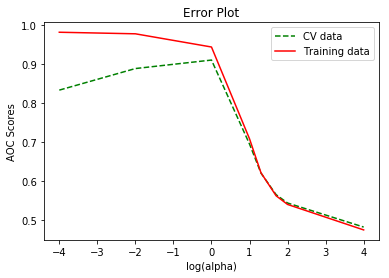

In [69]:
hyperSearch(train_cnt,cv_cnt,y_train,y_cv)

In [30]:
clf=MultinomialNB(alpha=1) #fitting MultinomialNB on test data with optimal value of hyperparameter alpha
clf.fit(train_cnt, y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

#### ROC Curve for training and test dataset

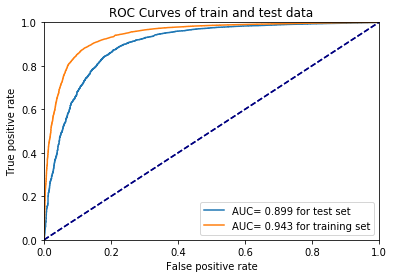

In [31]:
rocPlot(test_cnt, train_cnt, y_train, y_test)

#### Confusion matrix plot for training as well as test data

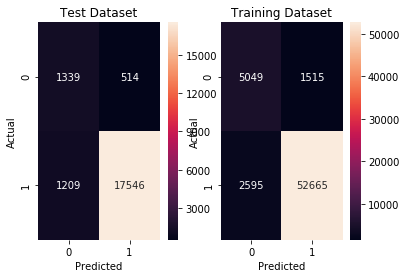

In [32]:
pred=clf.predict(test_cnt)
pred_train=clf.predict(train_cnt)
con_mx(pred, y_test, pred_train, y_train)
coeff=clf.coef_[0]

### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [33]:
%%time
features_10=np.argpartition(coeff,-10)[-10:] #only to sort incides oftop 10 weights
for i in features_10:
    print(vect.get_feature_names()[i], end=', ')

love, tea, one, taste, great, product, like, flavor, good, not, Wall time: 485 ms


### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [34]:
%%time
neg_10=np.argpartition(coeff,10)[:10] #indices of top 10 features from negative class
for i in neg_10:
    print(vect.get_feature_names()[i], end=', ')


leftmore, slipperiness, slayton, leke, drk, breatkfast, legitimately, drooped, breathalyser, slang, Wall time: 520 ms


## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

#### AUC vs log(alpha) to find optimal alpha

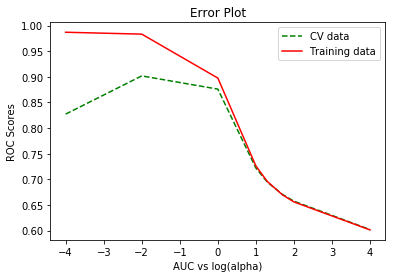

In [35]:
hyperSearch(train_tf,cv_tf,y_train,y_cv)

In [37]:
clf=MultinomialNB(alpha=0.01) #fitting MultinomialNB on test data with optimal value of hyperparameter alpha
clf.fit(train_tf, y_train)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

#### ROC Curve for training and test dataset

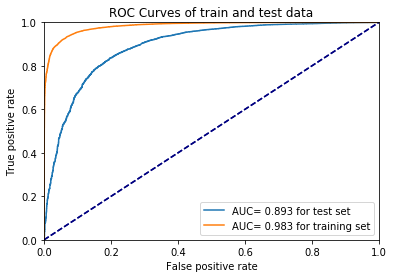

In [38]:
rocPlot(test_tf, train_tf, y_train, y_test)

#### Confusion matrix plot for training as well as test data

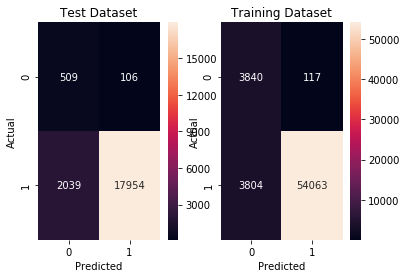

In [39]:
pred=clf.predict(test_tf)
pred_train=clf.predict(train_tf)
con_mx(pred, y_test, pred_train, y_train)

### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [40]:
coe=clf.coef_[0]
x=clf.feature_log_prob_[1]

In [41]:
%%time
features_10=np.argpartition(x,-10)[-10:] #only to sort incides oftop 10 weights & picking last 10
for i in features_10:
    print(idf.get_feature_names()[i], end=', ')

flavor, taste, product, like, good, coffee, love, tea, great, not, Wall time: 491 ms


### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [42]:
%%time
features_10=np.argpartition(coe,10)[:10] #only to sort incides oftop 10 weights and picking  top 10
for i in features_10:
    print(idf.get_feature_names()[i], end=', ')

coffeebeandirect, recoming, recibi, coffeeto, recive, coffeeplease, reckon, reclose, recognizethis, recoil, Wall time: 499 ms


# [5.3] Feature Engineering

In [61]:
df['demo']=df['CleanedText']+df['Summary']
textr=df['demo']
labelr=df['Score']
x,x_testf,y,y_testf=train_test_split(textr,labelr,test_size=0.2,random_state=0, stratify=labelr)
x_trainf,x_cvf,y_trainf,y_cvf=train_test_split(x,y,test_size=0.25, random_state=0, stratify=y)
vectt=CountVectorizer().fit(x_trainf)
train_r=vectt.transform(x_trainf)
cv_r=vectt.transform(x_cvf)
test_r=vectt.transform(x_testf)
tf=TfidfVectorizer().fit(x_trainf)
train_f=tf.transform(x_trainf)
cv_f=tf.transform(x_cvf)
test_f=tf.transform(x_testf)

Here, i have mergerd summary text alongwith review text and considering the text as a whole.
Further, splitting the data into BOW and TFIDF vectorizer.

## [5.3.1]BOW

#### AUC vs log(alpha) to find optimal alpha

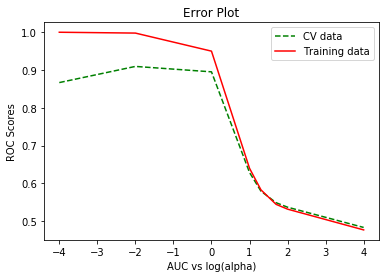

In [57]:
hyperSearch(train_r,cv_r,y_trainf,y_cvf)

In [58]:
clf=MultinomialNB(alpha=1) #fitting MultinomialNB on test data with optimal value of hyperparameter alpha
clf.fit(train_r, y_trainf)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

#### ROC Curve for training and test dataset

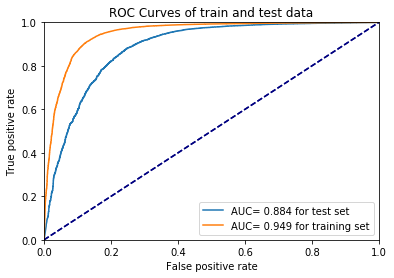

In [59]:
rocPlot(test_r, train_r, y_trainf, y_testf)

#### Confusion matrix plot for training as well as test data

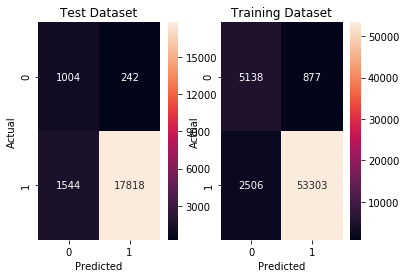

In [60]:
pred=clf.predict(test_r)
pred_train=clf.predict(train_r)
con_mx(pred, y_testf, pred_train, y_trainf)

## [5.3.2] TFIDF

#### AUC vs log(alpha) to find optimal alpha

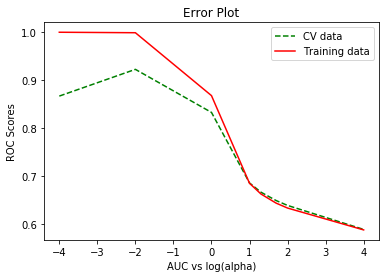

In [62]:
hyperSearch(train_f,cv_f,y_trainf,y_cvf)

In [63]:
clf=MultinomialNB(alpha=0.01) #fitting MultinomialNB on test data with optimal value of hyperparameter alpha
clf.fit(train_f, y_trainf)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

#### ROC Curve for training and test dataset

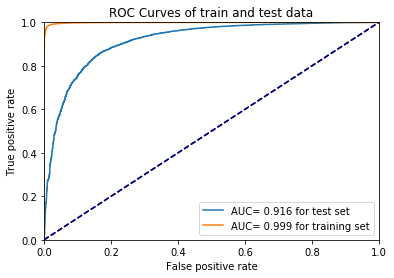

In [64]:
rocPlot(test_f, train_f, y_trainf, y_testf)

#### Confusion matrix plot for training as well as test data

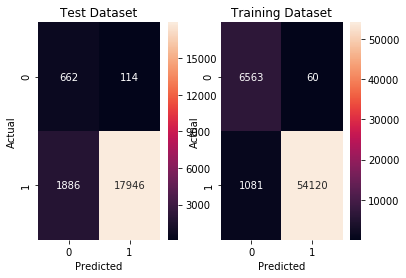

In [66]:
pred=clf.predict(test_f)
pred_train=clf.predict(train_f)
con_mx(pred, y_testf, pred_train, y_trainf)

# [6] Conclusions

In [67]:
from prettytable import PrettyTable
x=PrettyTable()
x.field_names=["Vectorizer", "Model", "Hyper Parameter", "AUC"]
x.add_row(["BOW", "MultinomialNB", 1, 0.899])
x.add_row(["TF-IDF","MultinomialNB", 0.01, 0.893])
x.add_row(["BOW(feature engg)", "MultinomialNB", 1, 0.884])
x.add_row(["TFIDF(feature engg)", "MultinomialNB", 0.01, 0.916])
print(x)

+---------------------+---------------+-----------------+-------+
|      Vectorizer     |     Model     | Hyper Parameter |  AUC  |
+---------------------+---------------+-----------------+-------+
|         BOW         | MultinomialNB |        1        | 0.899 |
|        TF-IDF       | MultinomialNB |       0.01      | 0.893 |
|  BOW(feature engg)  | MultinomialNB |        1        | 0.884 |
| TFIDF(feature engg) | MultinomialNB |       0.01      | 0.916 |
+---------------------+---------------+-----------------+-------+


here Naive Bayes is implemented on BOW and TFIDF vectorizers. It has one hyperparameter, alpha, who optimal value has found using cross validation and thus, fitting NB model with optimal alpha and finding AUC score on test as well as training data. Since, features are discrete so, multinomal NB has been used.

Further, feature engg. has been performed by merging summary and review data. For, BOW, there is slightly decrement in AUC and for TFIDF there is good increment in AUC of both training as well as test data.